In [65]:
import numpy as np
import requests
import gzip
import os
import hashlib
import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")

Using the latest cached version of the dataset since ylecun/mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'mnist' at C:\Users\X\.cache\huggingface\datasets\ylecun___mnist\mnist\1.0.0\b06aab39e05f7bcd9635d18ed25d06eae523c574 (last modified on Sat Jul 13 21:37:09 2024).


In [67]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [68]:
type(ds)

datasets.dataset_dict.DatasetDict

In [69]:
type(ds['train'])

datasets.arrow_dataset.Dataset

In [70]:
X_train = ds['train']['image']
Y_train = ds['train']['label']
X_test = ds['test']['image']
Y_test = ds['test']['label']

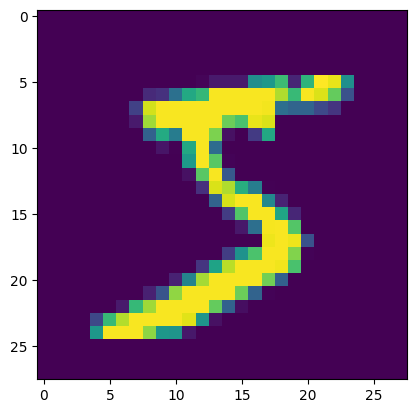

In [71]:
plt.imshow(X_train[0])

In [72]:
X_train = np.array(X_train).reshape(-1, 28*28)

In [73]:
X_train.shape

(60000, 784)

In [74]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [75]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.tensor(Y_train)
X_test = torch.from_numpy(np.array(X_test)).reshape(-1, 28*28).float()
Y_test = torch.tensor(Y_test)

In [76]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

model = MyNet()

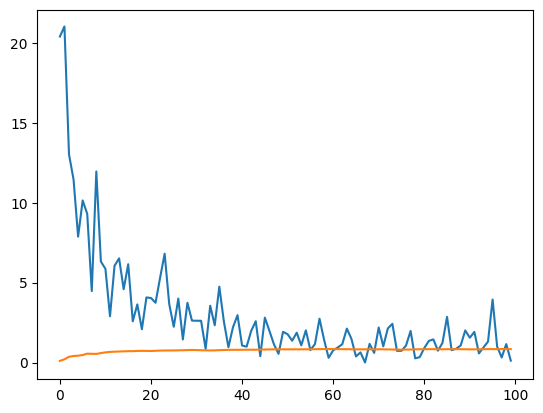

In [77]:
B = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accs = [], []
for i in range(100):
    samp =np.random.randint(0, X_train.shape[0], size=(B))
    X = X_train[samp]
    Y = Y_train[samp].long()
    optim.zero_grad()
    with torch.no_grad():
        size = X_test.shape[0]
        count = 0
        out = model(X_test)
        cat = torch.argmax(out, dim=1)
        acc = (cat == Y_test).float().mean()
        accs.append(acc)
    out = model(X)
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    losses.append(loss.item())
plt.plot(losses)
plt.plot(accs)